In [1]:
import sys
import os
sys.path.append(os.path.abspath("../"))  # or "../../" depending on location
from setup import add_project_root
add_project_root()

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from notebooks.evaluate_functions import *

from models.forward.FNO_models import FNO, FNO_noGrad
import time
import japanize_matplotlib

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
# load data
test_data = torch.load('../data/datasets/data/darcy_test_16.pt')
test_data_32 = torch.load("../data/datasets/data/darcy_test_32.pt")
x_test = test_data["x"].unsqueeze(1).float()
y_test = test_data["y"].unsqueeze(1).float()
x_test_32 = test_data_32["x"].unsqueeze(1).float()
y_test_32 = test_data_32["y"].unsqueeze(1).float()

# load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fno_withgrid = FNO(modes1=8, modes2=8, width=32).to(device)
fno_withgrid.load_state_dict(torch.load("../results/forward/checkpoints/best_darcy_fno_model.pth", map_location=device))
fno_withgrid.eval()

fno_nogrid = FNO_noGrad(modes1=8, modes2=8, width=32).to(device)
fno_nogrid.load_state_dict(torch.load("../results/forward/checkpoints/best_fno_noGrad_model.pth", map_location=device))
fno_nogrid.eval()


x_test = x_test.to(device)
y_test = y_test.to(device)

x_test_32 = x_test_32.to(device)
y_test_32 = y_test_32.to(device)


In [4]:
inference_times = {}
metrics = {}
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
with torch.no_grad():
    x_test_fno = x_test.permute(0, 2, 3, 1)
    # FNO with grid

    pred_withgrid = fno_withgrid(x_test_fno).cpu().numpy()

    inference_times["FNO with grid"] = measure_inference_time(fno_withgrid, x_test_fno, warmup=10, repeat=1000)
    metrics["FNO with grid"] = evaluate(pred_withgrid, y_test.cpu().numpy())
    print(f"FNO with grid params: {count_params(fno_withgrid)}")

    # FNO without grid
    pred_nogrid = fno_nogrid(x_test_fno).cpu().numpy()

    inference_times["FNO nogrid"] = measure_inference_time(fno_nogrid, x_test_fno, warmup=10, repeat=1000)
    metrics["FNO nogrid"] = evaluate(pred_nogrid, y_test.cpu().numpy())
    print(f"FNO nogrid params: {count_params(fno_nogrid)}")
    
    y_test = y_test.cpu().numpy()

print_inference_and_metrics(inference_times,metrics)

FNO with grid params: 204257
FNO nogrid params: 204193
【評価結果】

【推論時間（ms）】
FNO with grid  : 0.92 ms
FNO nogrid     : 0.79 ms

【評価指標】
Model                    MSE       PSNR       SSIM       HF_MSE
-----------------------------------------------------------------
FNO with grid     1.8002e-01      20.96     0.9432   4.5290e+01
FNO nogrid        1.7464e-01      12.49     0.7131   4.4261e+01


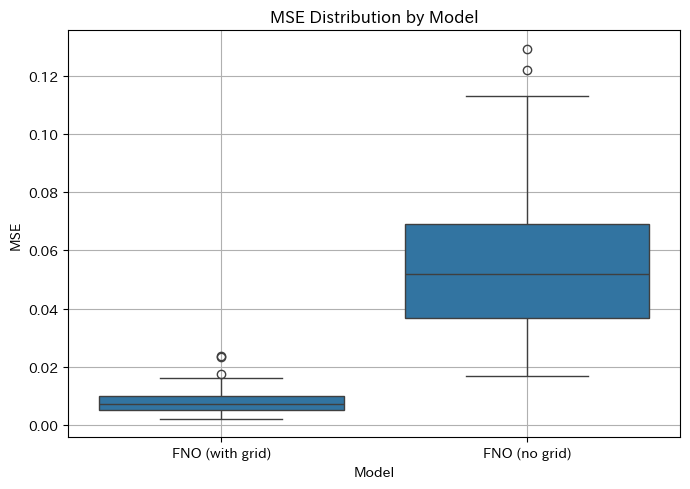

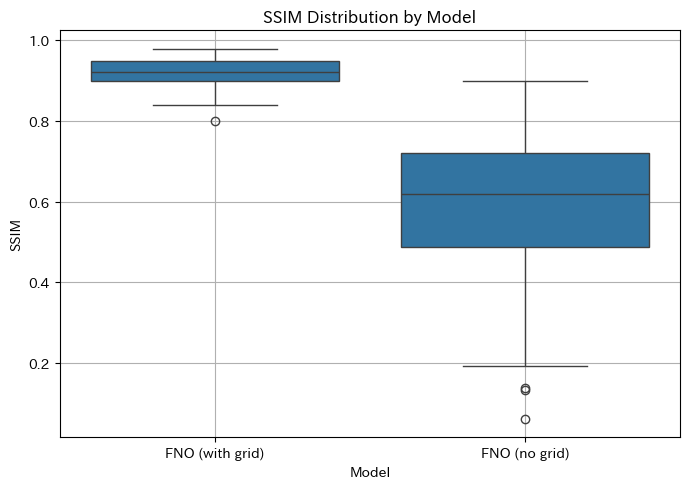

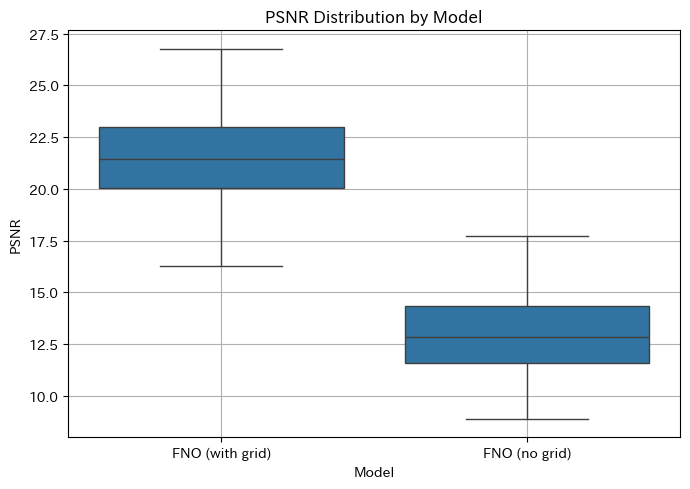

In [5]:
scores_withgrid = evaluate_all(pred_withgrid, y_test)
scores_nogrid = evaluate_all(pred_nogrid, y_test)

mse_withgrid  = [s["MSE"] for s in scores_withgrid]
mse_nogrid    = [s["MSE"] for s in scores_nogrid]
ssim_withgrid = [s["SSIM"] for s in scores_withgrid]
ssim_nogrid   = [s["SSIM"] for s in scores_nogrid]
psnr_withgrid = [s["PSNR"] for s in scores_withgrid]
psnr_nogrid   = [s["PSNR"] for s in scores_nogrid]

boxplot_metric_comparison({
    "FNO (with grid)": mse_withgrid,
    "FNO (no grid)": mse_nogrid,
}, metric_name="MSE")

boxplot_metric_comparison({
    "FNO (with grid)": ssim_withgrid,
    "FNO (no grid)": ssim_nogrid,
}, metric_name="SSIM")

boxplot_metric_comparison({
    "FNO (with grid)": psnr_withgrid,
    "FNO (no grid)": psnr_nogrid,
}, metric_name="PSNR")

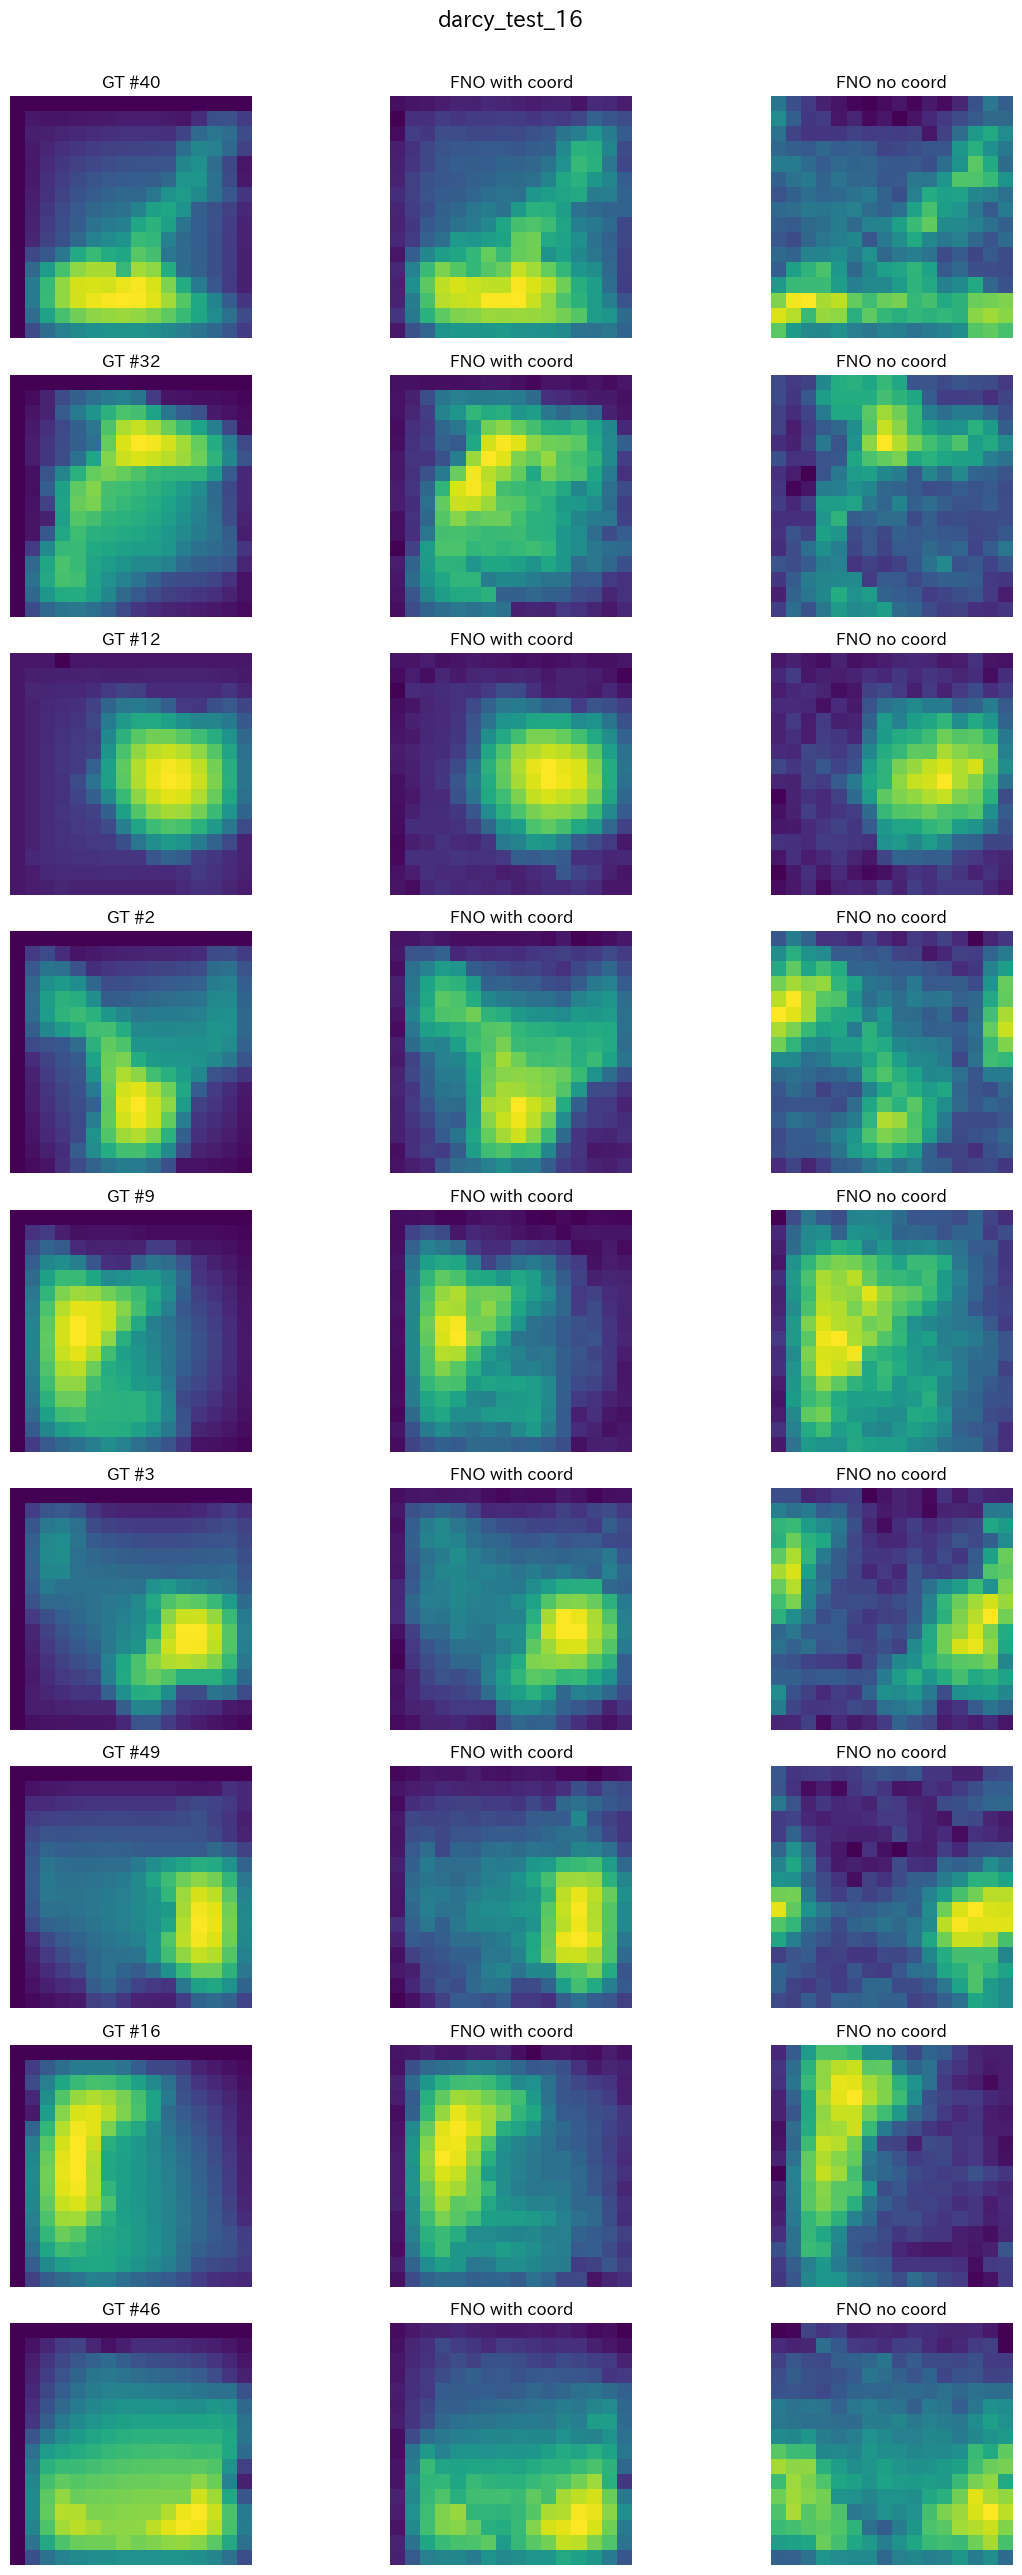

In [6]:
gt_images = y_test.squeeze(1)
fno_withgrid_images = pred_withgrid.squeeze(-1)
fno_nogrid_images = pred_nogrid.squeeze(-1)
plot_gt_pred_comparison(
    gt_images, [fno_withgrid_images, fno_nogrid_images],
    ["FNO with coord", "FNO no coord"], 
    title = "darcy_test_16")

c:\Users\natsu\OneDrive - 国立大学法人東北大学\研究室\python\FNOorCNN\root\notebooks\evaluate_functions.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.94])


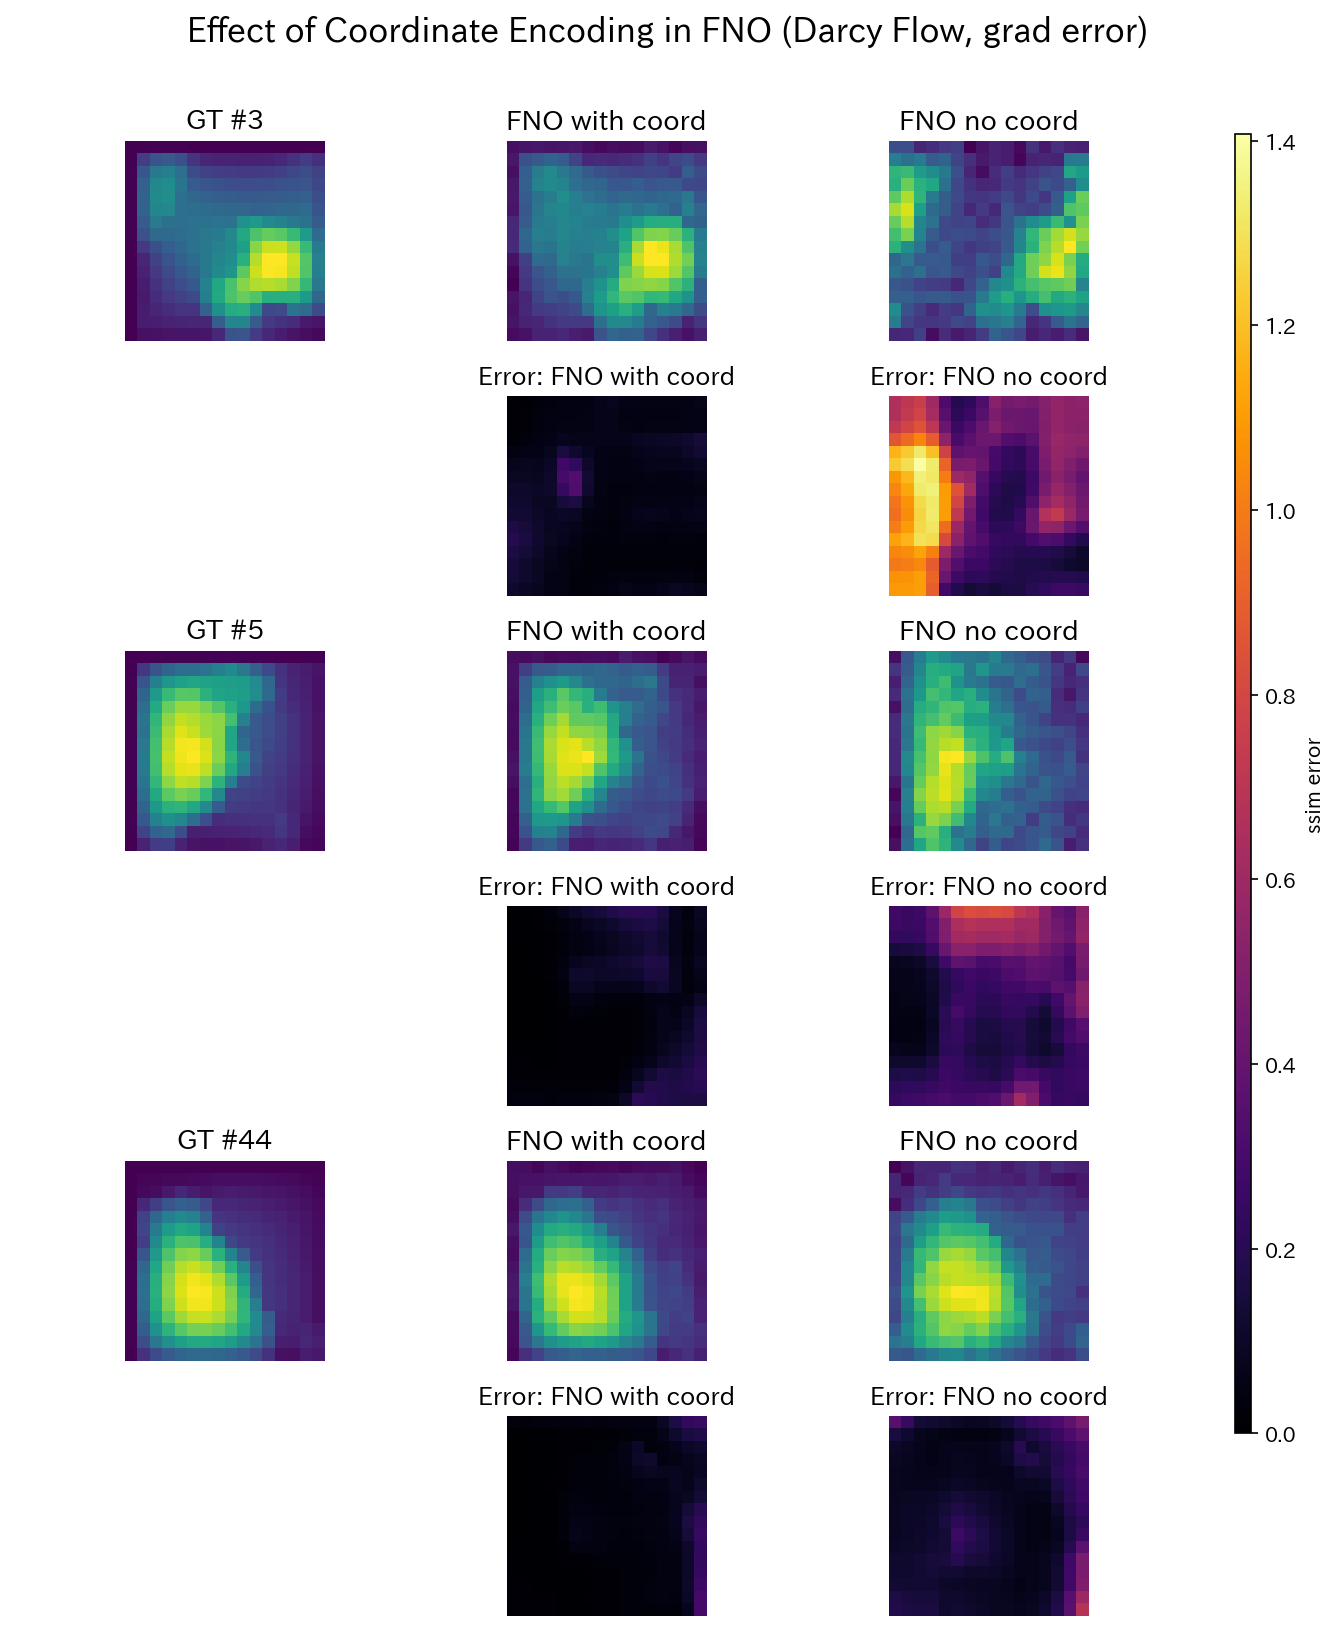

In [ ]:
error_type = "ssim" # error_type = "abs", "square", "grad","ssim"から選択
plot_comparison_with_error_maps(
    gt_images, [fno_withgrid_images, fno_nogrid_images], 
    ["FNO with coord", "FNO no coord"], 
    title = "Effect of Coordinate Encoding in FNO (Darcy Flow, grad error)",error_type=error_type,num_samples=3)

In [8]:
#　高解像度用
inference_times_32 = {}
metrics_32 = {}

with torch.no_grad():
    x_test_fno_32= x_test_32.permute(0, 2, 3, 1)
    # FNO with grid
    start_time = time.time()
    pred_withgrid_32 = fno_withgrid(x_test_fno_32).cpu().numpy()
    end_time = time.time()
    inference_times_32["FNO with grid"] = end_time - start_time
    metrics_32["FNO with grid"] = evaluate(pred_withgrid_32, y_test_32.cpu().numpy())

    # FNO without grid
    start_time = time.time()
    pred_nogrid_32 = fno_nogrid(x_test_fno_32).cpu().numpy()
    end_time = time.time()
    inference_times_32["FNO nogrid"] = end_time - start_time
    metrics_32["FNO nogrid"] = evaluate(pred_nogrid_32, y_test_32.cpu().numpy())
    
    y_test_32 = y_test_32.cpu().numpy()
    
    
print_inference_and_metrics(inference_times_32,metrics_32)


【評価結果】

【推論時間（ms）】
FNO with grid  : 6.85 ms
FNO nogrid     : 2.00 ms

【評価指標】
Model                    MSE       PSNR       SSIM       HF_MSE
-----------------------------------------------------------------
FNO with grid     1.7411e-01      19.47     0.9122   1.7880e+02
FNO nogrid        1.7161e-01      12.54     0.7059   1.7685e+02


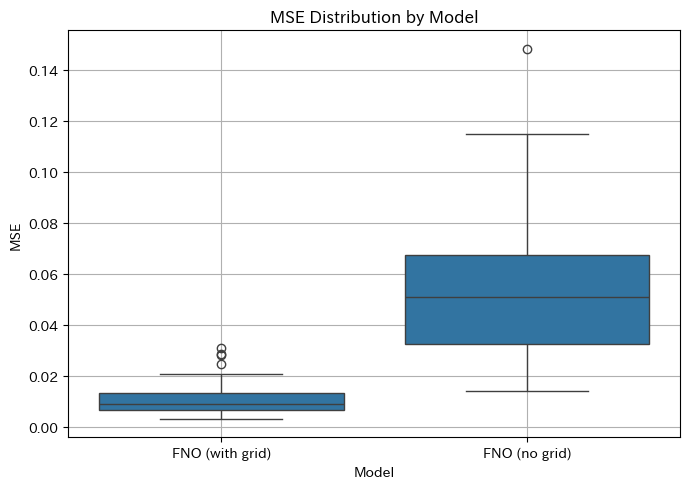

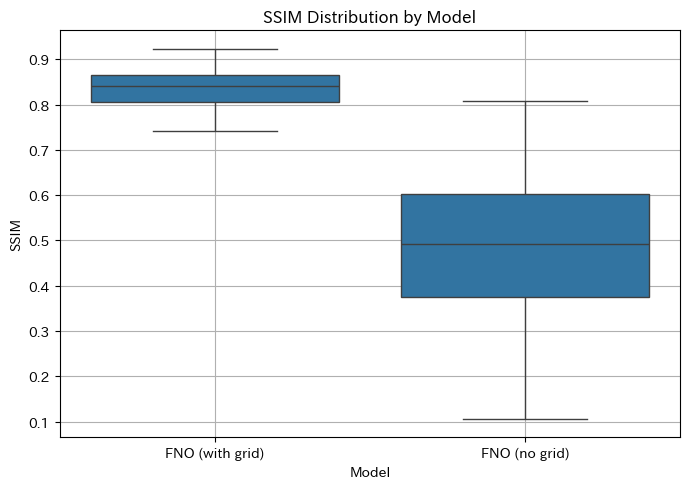

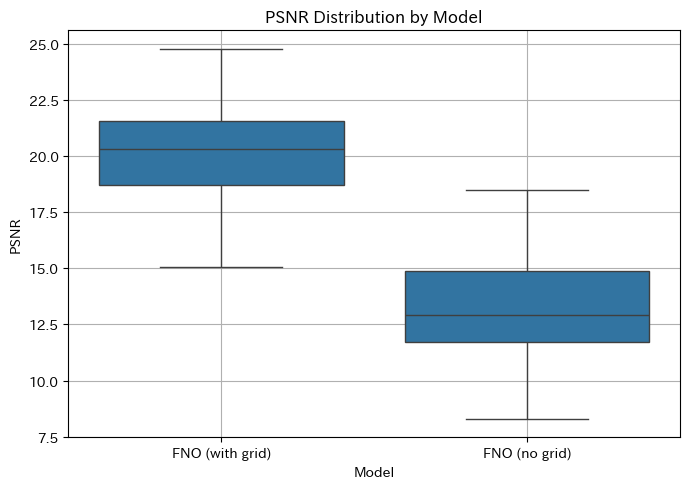

In [9]:
# === サンプル単位のスコア算出（解像度32） ===
scores_withgrid_32 = evaluate_all(pred_withgrid_32, y_test_32)
scores_nogrid_32   = evaluate_all(pred_nogrid_32, y_test_32)

# === 指標抽出 ===
mse_withgrid_32  = [s["MSE"] for s in scores_withgrid_32]
mse_nogrid_32    = [s["MSE"] for s in scores_nogrid_32]
ssim_withgrid_32 = [s["SSIM"] for s in scores_withgrid_32]
ssim_nogrid_32   = [s["SSIM"] for s in scores_nogrid_32]
psnr_withgrid_32 = [s["PSNR"] for s in scores_withgrid_32]
psnr_nogrid_32   = [s["PSNR"] for s in scores_nogrid_32]

# === 箱ひげ図で分布を可視化 ===
boxplot_metric_comparison({
    "FNO (with grid)": mse_withgrid_32,
    "FNO (no grid)": mse_nogrid_32,
}, metric_name="MSE")

boxplot_metric_comparison({
    "FNO (with grid)": ssim_withgrid_32,
    "FNO (no grid)": ssim_nogrid_32,
}, metric_name="SSIM")

boxplot_metric_comparison({
    "FNO (with grid)": psnr_withgrid_32,
    "FNO (no grid)": psnr_nogrid_32,
}, metric_name="PSNR")


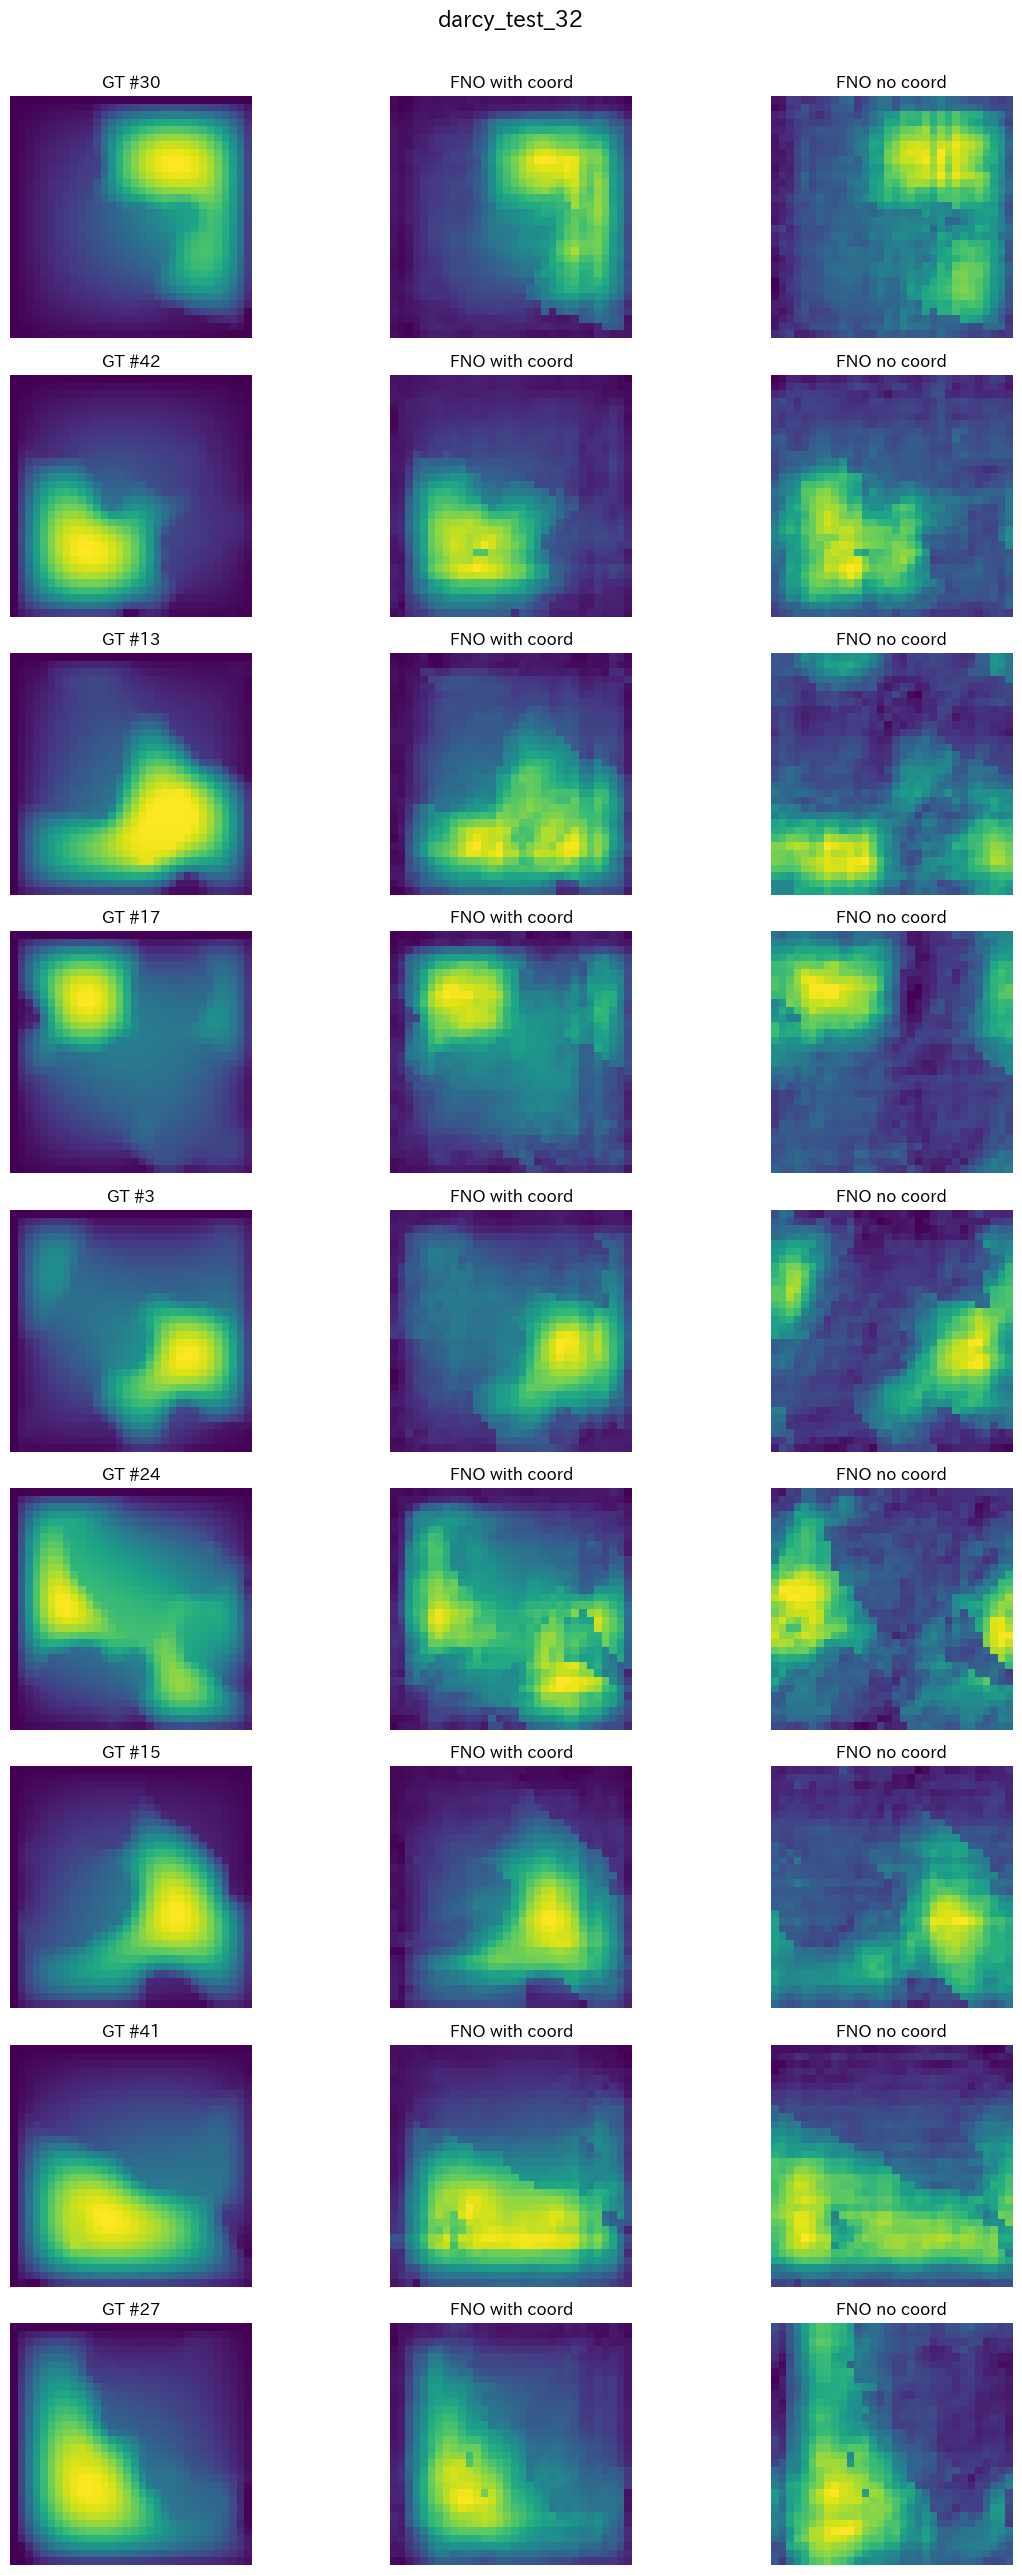

In [10]:
gt_images_32 = y_test_32.squeeze(1)
fno_withgrid_images_32 = pred_withgrid_32.squeeze(-1)
fno_nogrid_images_32 = pred_nogrid_32.squeeze(-1)

plot_gt_pred_comparison(
    gt_images_32,
    [fno_withgrid_images_32, fno_nogrid_images_32],
    labels = ["FNO with coord", "FNO no coord"],
    title = "darcy_test_32")

c:\Users\natsu\OneDrive - 国立大学法人東北大学\研究室\python\FNOorCNN\root\notebooks\evaluate_functions.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.94])


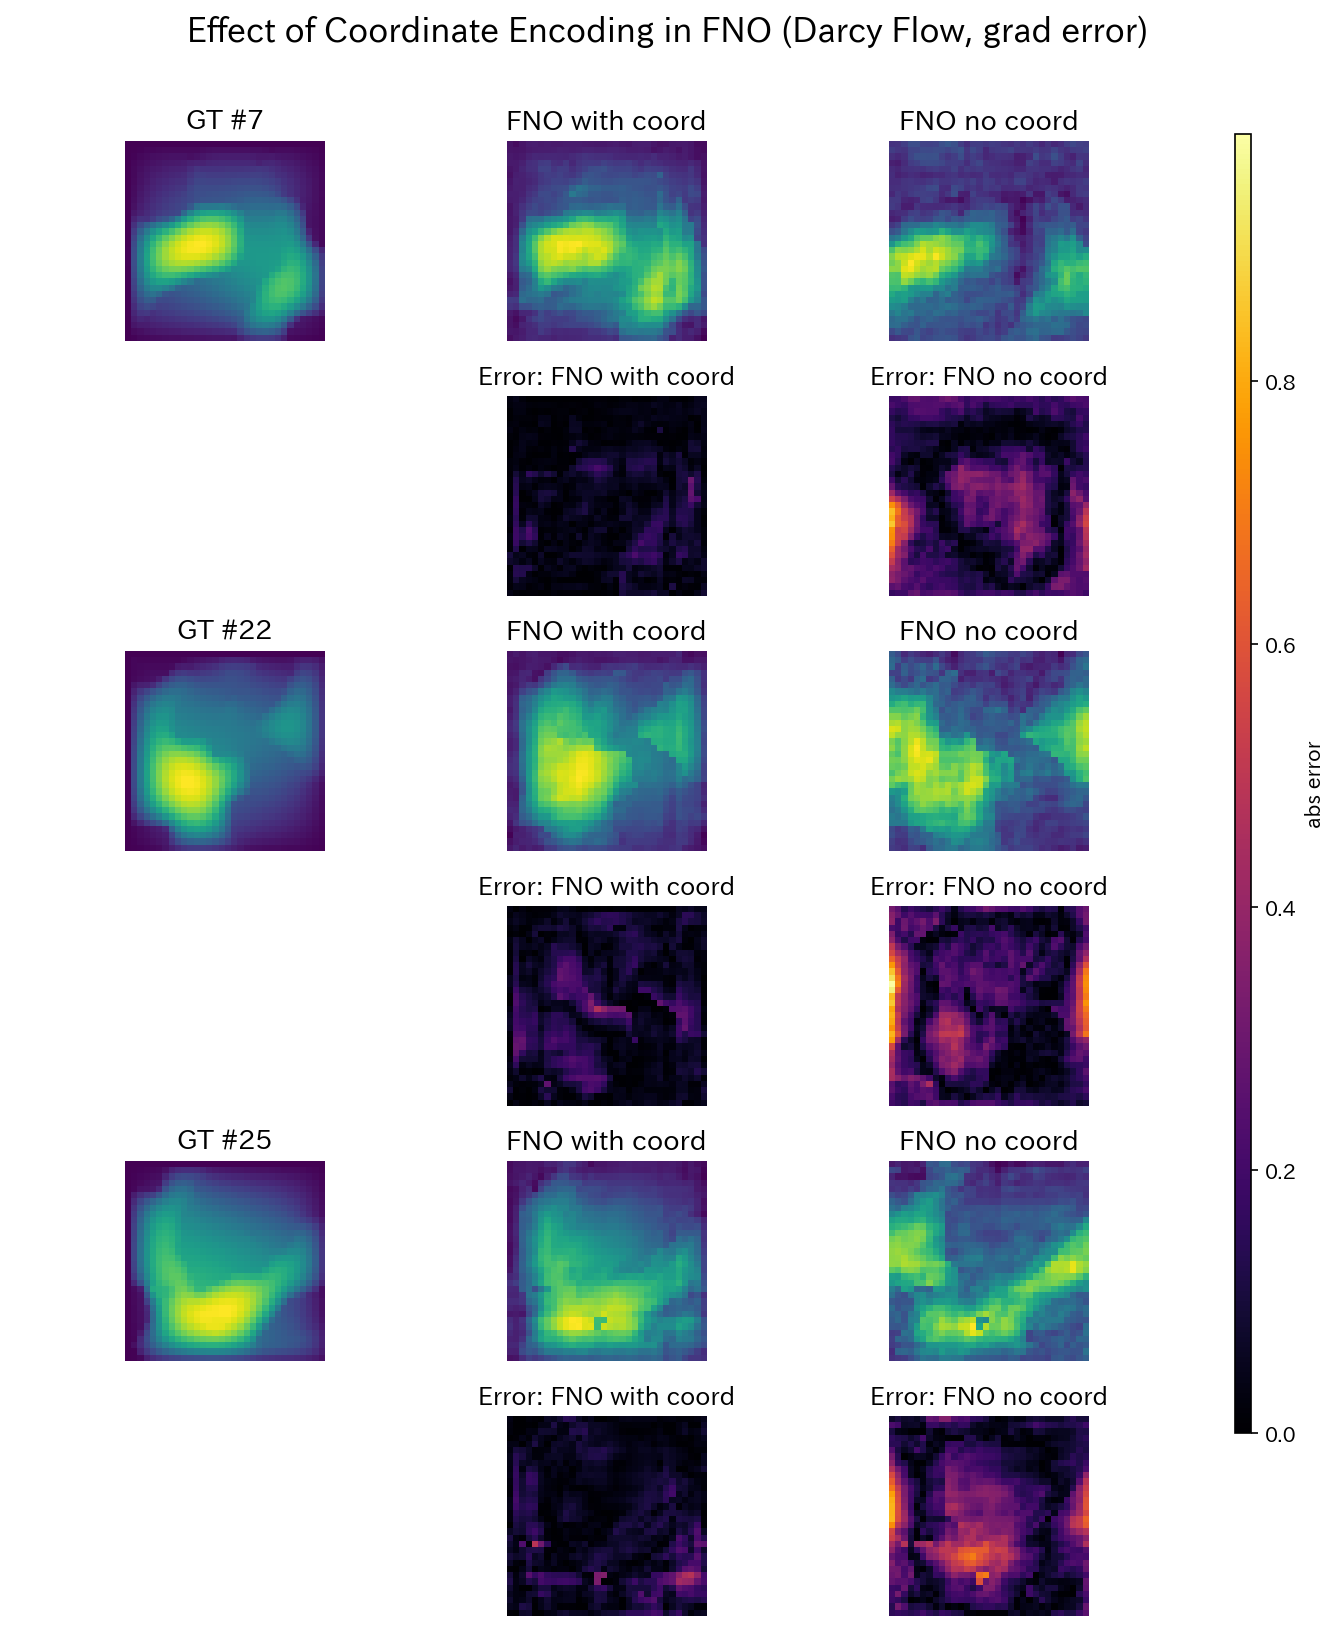

In [ ]:
# error_type = "abs", "square", "grad","ssim"から選択
error_type = "ssim" # error_type = "abs", "square", "grad","ssim"から選択
plot_comparison_with_error_maps(
    gt_images_32,
    [fno_withgrid_images_32, fno_nogrid_images_32],
    labels=["FNO with coord","FNO no coord"],
    title = "Effect of Coordinate Encoding in FNO (Darcy Flow, grad error)",error_type=error_type,num_samples=3)